In [1]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [5]:
#Acesso às pastas contendo os arquivos de áudio de cada ator

dir_list = os.listdir('Documents/Faculdade/TCC/audios/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [6]:
# Criação do data frame contendo as informações dos arquivos de áudio
initial_df = pd.DataFrame(columns=['path', 'emotion','intensity',
                                   'statement','repeat', 'actor', 'gender'])
count = 0
for i in dir_list:
    file_list = os.listdir('Documents/Faculdade/TCC/audios/' + i)
    for f in file_list:
        file_name = f.split('.')[0].split('-')
        path = 'Documents/Faculdade/TCC/audios/' + i + '/' + f
        actor = int(file_name[-1])
        emotion = int(file_name[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if file_name[3] == '01':
            intensity = 'normal'
        else:
            intensity = 'strong'
        
        if file_name[4] == '01':
            statement = 'statement 1'
        else:
            statement = 'statement 2'
        
        if file_name[5] == '01':
            repeat = 1
        else:
            repeat = 2
            
        initial_df.loc[count] = [path, emotion, intensity, statement, repeat, actor, gender]
        count += 1

In [7]:
print (len(initial_df))
initial_df.head()

1440


,path,emotion,intensity,statement,repeat,actor,gender
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,strong,statement 2,1,1,male
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,normal,statement 1,1,1,male
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,5,normal,statement 2,1,1,male
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,normal,statement 2,2,1,male
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,strong,statement 1,2,1,male


In [8]:
filename = initial_df.path[1024]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

Documents/Faculdade/TCC/audios/Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [9]:
# Corte do áudio para retirar a parte silenciosa
trim, trim_rate = librosa.effects.trim(samples, top_db=30)
trim, trim_rate

(array([-1.9141038e-07, -4.1607140e-07,  2.0688096e-06, ...,
         5.6699279e-05,  2.1195672e-05,  3.1794041e-06], dtype=float32),
 array([20992, 58880]))

In [10]:
# Áudio original
ipd.Audio(samples, rate=sample_rate)

In [11]:
# Áudio após o corte
ipd.Audio(trim, rate=sample_rate)

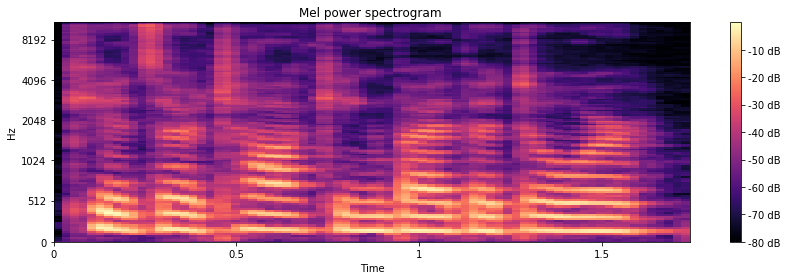

In [12]:
# Geração do espectrograma Mel Power

S = librosa.feature.melspectrogram(trim, sr=sample_rate, n_mels=128)

# Converte pra db
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

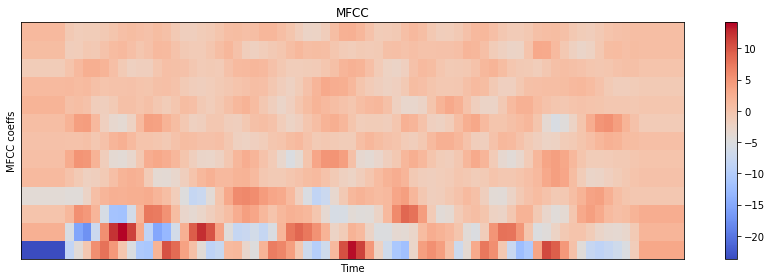

In [13]:
# Geração do MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Definindo um label para cada arquivo considerando a emoção

label_list = []
for i in range(len(initial_df)):
    if initial_df.emotion[i] == 1:
        lb = "neutral"
    elif initial_df.emotion[i] == 2:
        lb = "calm"
    elif initial_df.emotion[i] == 3:
        lb = "happy"
    elif initial_df.emotion[i] == 4:
        lb = "sad"
    elif initial_df.emotion[i] == 5:
        lb = "angry"
    elif initial_df.emotion[i] == 6:
        lb = "fearful"
    elif initial_df.emotion[i] == 7:
        lb = "disgust"
    elif initial_df.emotion[i] == 8:
        lb = "surprised"
         
    label_list.append(lb)
    
len(label_list)

1440

In [15]:
initial_df['label'] = label_list
initial_df.head()

,path,emotion,intensity,statement,repeat,actor,gender,label
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,strong,statement 2,1,1,male,surprised
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,normal,statement 1,1,1,male,surprised
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,5,normal,statement 2,1,1,male,angry
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,normal,statement 2,2,1,male,fearful
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,strong,statement 1,2,1,male,fearful


In [16]:
#Criação de um data frame separado apenas para homens
df_male = initial_df[initial_df.gender != "female"].reset_index(drop=True)
df_male.head()

,path,emotion,intensity,statement,repeat,actor,gender,label
0,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,strong,statement 2,1,1,male,surprised
1,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,8,normal,statement 1,1,1,male,surprised
2,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,5,normal,statement 2,1,1,male,angry
3,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,normal,statement 2,2,1,male,fearful
4,Documents/Faculdade/TCC/audios/Actor_01/03-01-...,6,strong,statement 1,2,1,male,fearful


In [17]:
print(len(df_male))

720


In [18]:
# Geração de um dataframe contendo apenas os valores de feature do mfccs feminino
df_feature_male = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(df_male))):
    X, sample_rate = librosa.load(df_male.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    df_feature_male.loc[i] = [feature]

100%|██████████| 720/720 [00:36<00:00, 19.60it/s]


In [19]:
df_feature_male.head()

,feature
0,"[-61.862373, -61.862373, -61.862373, -61.86237..."
1,"[-61.507996, -61.507996, -61.507996, -61.50799..."
2,"[-55.663086, -56.170334, -56.157845, -54.66347..."
3,"[-63.523525, -63.523525, -63.523525, -63.52352..."
4,"[-43.19739, -44.238605, -43.996212, -44.13236,..."


In [20]:
#Conversão dos valores de feature obtidos em uma lista de features
male_feature = pd.DataFrame(df_feature_male['feature'].values.tolist())
male_labels = initial_df.label

In [21]:
male_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373
1,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,-61.507996,-61.507996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336
3,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.889992,-63.725601,-62.940964,-63.046486,-63.523525,-63.523525,-63.523525,-62.370125,-61.950615,-63.523525
4,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,-40.030666,-40.667130,-38.647114,-38.187950,-39.104439,-41.083157,-39.765232,-41.423752,-43.453789,-43.185612


In [22]:
male_feature_lbl = pd.concat([male_feature,male_labels], axis=1)

In [23]:
male_feature_labels = male_feature_lbl.rename(index=str, columns={"0": "label"})
len(male_feature_labels)

1440

In [24]:
male_feature_labels.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,surprised
1,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,-61.507996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,surprised
2,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,angry
3,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940964,-63.046486,-63.523525,-63.523525,-63.523525,-62.370125,-61.950615,-63.523525,fearful
4,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,-40.667130,-38.647114,-38.187950,-39.104439,-41.083157,-39.765232,-41.423752,-43.453789,-43.185612,fearful
5,-42.991745,-42.991745,-42.845966,-42.267849,-40.690147,-40.163383,-40.072178,-42.603901,-41.733139,-41.410767,...,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,angry
6,-54.985142,-54.914570,-54.937820,-56.227646,-56.685261,-57.022507,-58.089943,-58.376122,-58.420403,-56.623604,...,-64.638062,-65.028267,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,-65.215340,disgust
7,-67.736153,-67.778015,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,sad
8,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,...,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,sad
9,-46.453178,-42.248955,-41.289631,-39.171280,-37.144573,-35.734550,-35.904476,-36.825901,-39.269676,-38.772984,...,-55.540245,-54.272846,-53.866123,-55.657780,-54.114990,-53.178421,-53.144508,-53.745079,-55.749142,disgust


In [25]:
#Geração do gráfico de frequência da voz
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

#Reduzir o barulho
def noise(data):
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

#Organizar as linhas do array de forma aleatória
def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)

#Esticar o som
def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

#Afinar o tom da voz
def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

#Mudar valores de forma aleatória
def dyn_change(data):
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)

#Alterar velocidade do tom
def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [26]:
# Aplicação de um método de Augmentation

syn_data1f = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(initial_df))):
    X, sample_rate = librosa.load(initial_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if initial_df.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1f.loc[i] = [feature, initial_df.label[i]]

100%|██████████| 1440/1440 [01:24<00:00, 17.11it/s]


In [27]:
# Aplicação de outro método de Augmentation

syn_data2f = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(initial_df))):
    X, sample_rate = librosa.load(initial_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if initial_df.label[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2f.loc[i] = [feature, initial_df.label[i]]

100%|██████████| 1440/1440 [05:47<00:00,  4.14it/s]


In [28]:
len(syn_data1f), len(syn_data2f)

(1440, 1440)

In [29]:
syn_data1f = syn_data1f.reset_index(drop=True)
syn_data2f = syn_data2f.reset_index(drop=True)

In [30]:
featf = pd.DataFrame(syn_data1f['feature'].values.tolist())
labelsf = syn_data1f.label
syndf1_male = pd.concat([featf,labelsf], axis=1)
syndf1_male = syndf1_male.rename(index=str, columns={"0": "label"})
syndf1_male = syndf1_male.fillna(0)
len(syndf1_male)

1440

In [31]:
syndf1_male.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.863533,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,...,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862461,-61.862492,surprised
1,-49.935398,-46.753666,-48.067772,-49.667564,-48.547974,-49.622261,-49.562180,-49.159416,-51.193272,-50.134010,...,-49.399040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprised
2,-53.274353,-52.459183,-53.077152,-51.984818,-52.561638,-53.264046,-52.054852,-52.256332,-52.534500,-52.671261,...,-52.750771,-53.250145,-52.390217,-49.354240,-48.958408,-50.998787,-50.777565,-49.623737,-50.190166,angry
3,-55.112831,-54.104286,-56.859432,-55.900394,-55.852638,-56.408928,-54.107857,-54.140163,-55.054195,-55.909912,...,-54.092361,-57.125187,-56.182419,-55.082413,-54.831863,-55.238464,-55.187943,-57.158707,-58.228638,fearful
4,-34.999699,-33.808346,-33.620678,-32.321690,-31.748869,-31.252251,-31.877754,-34.299511,-33.919308,-34.421970,...,-32.362816,-32.166286,-31.651121,-30.493290,-32.045597,-32.522240,-34.252251,-35.172470,-33.389141,fearful


In [32]:
featf2 = pd.DataFrame(syn_data2f['feature'].values.tolist())
labelsf2 = syn_data2f.label
syndf2_male = pd.concat([featf2,labelsf2], axis=1)
syndf2_male = syndf2_male.rename(index=str, columns={"0": "label"})
syndf2_male = syndf2_male.fillna(0)
len(syndf2_male)

1440

In [33]:
syndf2_male.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,...,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,-63.630703,surprised
1,-67.443100,-67.443100,-67.443100,-67.443100,-67.443100,-67.443100,-67.443100,-67.443100,-67.443100,-67.443100,...,-67.443100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprised
2,-56.307552,-56.869164,-56.427620,-56.151974,-56.895142,-56.895245,-56.895245,-56.895245,-56.895245,-56.895245,...,-56.895245,-56.895245,-56.895245,-56.817448,-56.780197,-56.895245,-56.895245,-56.895245,-56.895245,angry
3,-65.843781,-65.844315,-65.844315,-65.844315,-65.844315,-65.570465,-64.993599,-65.678558,-65.844315,-65.844315,...,-65.959976,-65.328827,-65.048912,-65.844315,-65.772041,-65.744255,-65.138931,-65.028145,-65.844315,fearful
4,-43.946175,-46.664612,-48.011330,-47.907341,-48.199825,-48.039700,-47.770687,-48.434597,-48.839882,-48.599068,...,-46.615379,-45.959263,-45.627850,-46.531437,-45.961403,-44.188950,-45.437260,-47.960506,-49.232449,fearful


In [34]:
# Combinar os dados Augmented com os originais
combined_df_male = pd.concat([male_feature_labels, syndf1_male, syndf2_male], ignore_index=True)
combined_df_male = combined_df_male.fillna(0)
combined_df_male.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,surprised
1,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,-61.507996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprised
2,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,angry
3,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940964,-63.046486,-63.523525,-63.523525,-63.523525,-62.370125,-61.950615,-63.523525,fearful
4,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,-40.667130,-38.647114,-38.187950,-39.104439,-41.083157,-39.765232,-41.423752,-43.453789,-43.185612,fearful


In [35]:
#  Stratified Shuffle Split - divide a base em treino e teste 

X = combined_df_male.drop(['label'], axis=1)
y = combined_df_male.label
data_split = StratifiedShuffleSplit(10, test_size=0.25, random_state=12)
for train_index, test_index in data_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [36]:
y_train.value_counts()

happy        432
sad          432
angry        432
fearful      432
surprised    432
disgust      432
calm         432
neutral      216
Name: label, dtype: int64

In [37]:
#Converter os dados de treino e teste em arrays numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
#Converter os dados do array em dados categóricos
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [38]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
X_train.shape

(3240, 259)

In [40]:
#Expande as dimensões do array
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [41]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [42]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

Instructions for updating:
Colocations handled automatically by placer.


In [43]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)          

In [44]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [45]:
# Model Training
filepath="aug_noiseNshift_2class2_np.h5"
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Instructions for updating:
Use tf.cast instead.
Train on 3240 samples, validate on 1080 samples
Epoch 1/700
3240/3240 [==============================] - 90s 28ms/step - loss: 2.0910 - accuracy: 0.1463 - fscore: 0.0000e+00 - val_loss: 2.0681 - val_accuracy: 0.1370 - val_fscore: 0.0000e+00
Epoch 2/700
3240/3240 [==============================] - 98s 30ms/step - loss: 2.0477 - accuracy: 0.1636 - fscore: 0.0000e+00 - val_loss: 2.0392 - val_accuracy: 0.1843 - val_fscore: 0.0000e+00
Epoch 3/700
3240/3240 [==============================] - 77s 24ms/step - loss: 2.0308 - accuracy: 0.1892 - fscore: 0.0000e+00 - val_loss: 2.0226 - val_accuracy: 0.2139 - val_fscore: 0.0000e+00
Epoch 4/700
3240/3240 [==============================] - 74s 23ms/step - loss: 2.0171 - accuracy: 0.2062 - fscore: 0.0000e+00 - val_loss: 2.0142 - val_accuracy: 0.2315 - val_fscore: 0.0000e+00
Epoch 5/700
3240/3240 [==============================] - 75s 23ms/step - loss: 2.0055 - accuracy: 0.2120 - fscore: 0.0000e+00 - val_

3240/3240 [==============================] - 72s 22ms/step - loss: 1.8297 - accuracy: 0.2988 - fscore: 0.0369 - val_loss: 1.8889 - val_accuracy: 0.2824 - val_fscore: 0.0000e+00
Epoch 43/700
3240/3240 [==============================] - 72s 22ms/step - loss: 1.8193 - accuracy: 0.3037 - fscore: 0.0379 - val_loss: 1.8902 - val_accuracy: 0.2824 - val_fscore: 0.0000e+00
Epoch 44/700
3240/3240 [==============================] - 72s 22ms/step - loss: 1.8137 - accuracy: 0.3043 - fscore: 0.0430 - val_loss: 1.8832 - val_accuracy: 0.3037 - val_fscore: 0.0000e+00
Epoch 45/700
3240/3240 [==============================] - 72s 22ms/step - loss: 1.8108 - accuracy: 0.3049 - fscore: 0.0462 - val_loss: 1.8678 - val_accuracy: 0.2944 - val_fscore: 0.0000e+00
Epoch 46/700
3240/3240 [==============================] - 71s 22ms/step - loss: 1.8135 - accuracy: 0.3160 - fscore: 0.0548 - val_loss: 1.8688 - val_accuracy: 0.2981 - val_fscore: 0.0000e+00
Epoch 47/700
3240/3240 [==============================] - 72s 2

3240/3240 [==============================] - 88s 27ms/step - loss: 1.7040 - accuracy: 0.3667 - fscore: 0.1143 - val_loss: 1.8227 - val_accuracy: 0.3315 - val_fscore: 0.0017
Epoch 86/700
3240/3240 [==============================] - 77s 24ms/step - loss: 1.6968 - accuracy: 0.3772 - fscore: 0.1132 - val_loss: 1.8114 - val_accuracy: 0.3343 - val_fscore: 0.0068
Epoch 87/700
3240/3240 [==============================] - 85s 26ms/step - loss: 1.6940 - accuracy: 0.3802 - fscore: 0.1196 - val_loss: 1.8223 - val_accuracy: 0.3093 - val_fscore: 0.0069
Epoch 88/700
3240/3240 [==============================] - 87s 27ms/step - loss: 1.6964 - accuracy: 0.3673 - fscore: 0.1215 - val_loss: 1.8110 - val_accuracy: 0.3343 - val_fscore: 0.0052
Epoch 89/700
3240/3240 [==============================] - 468s 145ms/step - loss: 1.6869 - accuracy: 0.3833 - fscore: 0.1200 - val_loss: 1.7983 - val_accuracy: 0.3426 - val_fscore: 0.0087
Epoch 90/700
3240/3240 [==============================] - 126s 39ms/step - loss: 

Epoch 129/700
3240/3240 [==============================] - 65s 20ms/step - loss: 1.5700 - accuracy: 0.4336 - fscore: 0.2078 - val_loss: 1.7716 - val_accuracy: 0.3306 - val_fscore: 0.0354
Epoch 130/700
3240/3240 [==============================] - 65s 20ms/step - loss: 1.5599 - accuracy: 0.4321 - fscore: 0.2136 - val_loss: 1.7658 - val_accuracy: 0.3324 - val_fscore: 0.0305
Epoch 131/700
3240/3240 [==============================] - 65s 20ms/step - loss: 1.5556 - accuracy: 0.4429 - fscore: 0.2010 - val_loss: 1.8017 - val_accuracy: 0.3519 - val_fscore: 0.0204
Epoch 132/700
3240/3240 [==============================] - 65s 20ms/step - loss: 1.5642 - accuracy: 0.4373 - fscore: 0.2151 - val_loss: 1.7515 - val_accuracy: 0.3741 - val_fscore: 0.0255
Epoch 133/700
3240/3240 [==============================] - 65s 20ms/step - loss: 1.5586 - accuracy: 0.4448 - fscore: 0.2176 - val_loss: 1.7818 - val_accuracy: 0.3583 - val_fscore: 0.0220
Epoch 134/700
3240/3240 [==============================] - 65s 20

Epoch 173/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.4355 - accuracy: 0.4901 - fscore: 0.3129 - val_loss: 1.7563 - val_accuracy: 0.3435 - val_fscore: 0.0659
Epoch 174/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.4326 - accuracy: 0.5003 - fscore: 0.3157 - val_loss: 1.7013 - val_accuracy: 0.4009 - val_fscore: 0.0648
Epoch 175/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.4422 - accuracy: 0.4873 - fscore: 0.3072 - val_loss: 1.7361 - val_accuracy: 0.3556 - val_fscore: 0.0516
Epoch 176/700
3240/3240 [==============================] - 70s 22ms/step - loss: 1.4369 - accuracy: 0.4855 - fscore: 0.3226 - val_loss: 1.7373 - val_accuracy: 0.3537 - val_fscore: 0.0792
Epoch 177/700
3240/3240 [==============================] - 70s 22ms/step - loss: 1.4193 - accuracy: 0.5046 - fscore: 0.3202 - val_loss: 1.7029 - val_accuracy: 0.3926 - val_fscore: 0.0728
Epoch 178/700
3240/3240 [==============================] - 69s 21

Epoch 217/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.3020 - accuracy: 0.5451 - fscore: 0.4205 - val_loss: 1.6752 - val_accuracy: 0.4083 - val_fscore: 0.1097
Epoch 218/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.2936 - accuracy: 0.5451 - fscore: 0.4366 - val_loss: 1.6663 - val_accuracy: 0.3898 - val_fscore: 0.1133
Epoch 219/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.2952 - accuracy: 0.5463 - fscore: 0.4273 - val_loss: 1.7377 - val_accuracy: 0.3389 - val_fscore: 0.1093
Epoch 220/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.2932 - accuracy: 0.5488 - fscore: 0.4307 - val_loss: 1.6981 - val_accuracy: 0.3944 - val_fscore: 0.0827
Epoch 221/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.2946 - accuracy: 0.5494 - fscore: 0.4203 - val_loss: 1.6530 - val_accuracy: 0.4074 - val_fscore: 0.1279
Epoch 222/700
3240/3240 [==============================] - 69s 21

Epoch 261/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.1771 - accuracy: 0.5948 - fscore: 0.5003 - val_loss: 1.7868 - val_accuracy: 0.3204 - val_fscore: 0.1672
Epoch 262/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.1682 - accuracy: 0.5880 - fscore: 0.5116 - val_loss: 1.6727 - val_accuracy: 0.3954 - val_fscore: 0.1532
Epoch 263/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.1467 - accuracy: 0.6031 - fscore: 0.5368 - val_loss: 1.6601 - val_accuracy: 0.3880 - val_fscore: 0.1639
Epoch 264/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.1508 - accuracy: 0.6000 - fscore: 0.5284 - val_loss: 1.6550 - val_accuracy: 0.3981 - val_fscore: 0.1562
Epoch 265/700
3240/3240 [==============================] - 70s 21ms/step - loss: 1.1508 - accuracy: 0.5960 - fscore: 0.5169 - val_loss: 1.6482 - val_accuracy: 0.3991 - val_fscore: 0.1622
Epoch 266/700
3240/3240 [==============================] - 69s 21

Epoch 305/700
3240/3240 [==============================] - 70s 22ms/step - loss: 1.0469 - accuracy: 0.6373 - fscore: 0.5835 - val_loss: 1.5818 - val_accuracy: 0.4315 - val_fscore: 0.2325
Epoch 306/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.0624 - accuracy: 0.6213 - fscore: 0.5846 - val_loss: 1.6631 - val_accuracy: 0.3787 - val_fscore: 0.1980
Epoch 307/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.0572 - accuracy: 0.6265 - fscore: 0.5884 - val_loss: 1.6153 - val_accuracy: 0.4343 - val_fscore: 0.2653
Epoch 308/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.0412 - accuracy: 0.6355 - fscore: 0.5894 - val_loss: 1.6386 - val_accuracy: 0.4065 - val_fscore: 0.2055
Epoch 309/700
3240/3240 [==============================] - 69s 21ms/step - loss: 1.0450 - accuracy: 0.6346 - fscore: 0.5915 - val_loss: 1.6268 - val_accuracy: 0.4102 - val_fscore: 0.2290
Epoch 310/700
3240/3240 [==============================] - 69s 21

Epoch 349/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.9509 - accuracy: 0.6698 - fscore: 0.6351 - val_loss: 1.6355 - val_accuracy: 0.3954 - val_fscore: 0.2815
Epoch 350/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.9488 - accuracy: 0.6667 - fscore: 0.6415 - val_loss: 1.6043 - val_accuracy: 0.4102 - val_fscore: 0.2752
Epoch 351/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.9529 - accuracy: 0.6562 - fscore: 0.6353 - val_loss: 1.6246 - val_accuracy: 0.4185 - val_fscore: 0.2658
Epoch 352/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.9507 - accuracy: 0.6614 - fscore: 0.6353 - val_loss: 1.6346 - val_accuracy: 0.3926 - val_fscore: 0.2315
Epoch 353/700
3240/3240 [==============================] - 70s 22ms/step - loss: 0.9426 - accuracy: 0.6682 - fscore: 0.6485 - val_loss: 1.6428 - val_accuracy: 0.3963 - val_fscore: 0.2473
Epoch 354/700
3240/3240 [==============================] - 69s 21

Epoch 393/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8838 - accuracy: 0.6877 - fscore: 0.6781 - val_loss: 1.5788 - val_accuracy: 0.4407 - val_fscore: 0.3090
Epoch 394/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8676 - accuracy: 0.6954 - fscore: 0.6931 - val_loss: 1.6297 - val_accuracy: 0.4111 - val_fscore: 0.2610
Epoch 395/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8885 - accuracy: 0.6821 - fscore: 0.6771 - val_loss: 1.5887 - val_accuracy: 0.4417 - val_fscore: 0.3046
Epoch 396/700
3240/3240 [==============================] - 70s 21ms/step - loss: 0.8713 - accuracy: 0.6818 - fscore: 0.6812 - val_loss: 1.5997 - val_accuracy: 0.4324 - val_fscore: 0.3154
Epoch 397/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8711 - accuracy: 0.6790 - fscore: 0.6848 - val_loss: 1.5792 - val_accuracy: 0.4444 - val_fscore: 0.3033
Epoch 398/700
3240/3240 [==============================] - 70s 21

Epoch 437/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8057 - accuracy: 0.7114 - fscore: 0.7105 - val_loss: 1.5914 - val_accuracy: 0.4333 - val_fscore: 0.3251
Epoch 438/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8121 - accuracy: 0.7142 - fscore: 0.7100 - val_loss: 1.5709 - val_accuracy: 0.4556 - val_fscore: 0.3216
Epoch 439/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8197 - accuracy: 0.7062 - fscore: 0.7077 - val_loss: 1.6326 - val_accuracy: 0.4269 - val_fscore: 0.3140
Epoch 440/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8025 - accuracy: 0.7086 - fscore: 0.7096 - val_loss: 1.6106 - val_accuracy: 0.4065 - val_fscore: 0.3226
Epoch 441/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.8154 - accuracy: 0.7080 - fscore: 0.7075 - val_loss: 1.5886 - val_accuracy: 0.4370 - val_fscore: 0.3290
Epoch 442/700
3240/3240 [==============================] - 69s 21

Epoch 481/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.7634 - accuracy: 0.7241 - fscore: 0.7361 - val_loss: 1.6047 - val_accuracy: 0.4324 - val_fscore: 0.3331
Epoch 482/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.7659 - accuracy: 0.7253 - fscore: 0.7345 - val_loss: 1.6067 - val_accuracy: 0.4287 - val_fscore: 0.3148
Epoch 483/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.7732 - accuracy: 0.7136 - fscore: 0.7266 - val_loss: 1.5990 - val_accuracy: 0.4444 - val_fscore: 0.3425
Epoch 484/700
3240/3240 [==============================] - 73s 22ms/step - loss: 0.7676 - accuracy: 0.7191 - fscore: 0.7355 - val_loss: 1.5920 - val_accuracy: 0.4528 - val_fscore: 0.3566
Epoch 485/700
3240/3240 [==============================] - 73s 23ms/step - loss: 0.7719 - accuracy: 0.7182 - fscore: 0.7307 - val_loss: 1.6364 - val_accuracy: 0.4352 - val_fscore: 0.3415
Epoch 486/700
3240/3240 [==============================] - 70s 22

Epoch 525/700
3240/3240 [==============================] - 71s 22ms/step - loss: 0.7373 - accuracy: 0.7336 - fscore: 0.7495 - val_loss: 1.5994 - val_accuracy: 0.4426 - val_fscore: 0.3587
Epoch 526/700
3240/3240 [==============================] - 70s 22ms/step - loss: 0.7303 - accuracy: 0.7472 - fscore: 0.7556 - val_loss: 1.6144 - val_accuracy: 0.4306 - val_fscore: 0.3491
Epoch 527/700
3240/3240 [==============================] - 70s 22ms/step - loss: 0.7255 - accuracy: 0.7451 - fscore: 0.7594 - val_loss: 1.5877 - val_accuracy: 0.4481 - val_fscore: 0.3581
Epoch 528/700
3240/3240 [==============================] - 71s 22ms/step - loss: 0.7455 - accuracy: 0.7287 - fscore: 0.7495 - val_loss: 1.6295 - val_accuracy: 0.4296 - val_fscore: 0.3490
Epoch 529/700
3240/3240 [==============================] - 72s 22ms/step - loss: 0.7365 - accuracy: 0.7349 - fscore: 0.7478 - val_loss: 1.6217 - val_accuracy: 0.4407 - val_fscore: 0.3477
Epoch 530/700
3240/3240 [==============================] - 71s 22

Epoch 569/700
3240/3240 [==============================] - 71s 22ms/step - loss: 0.7196 - accuracy: 0.7330 - fscore: 0.7549 - val_loss: 1.6083 - val_accuracy: 0.4472 - val_fscore: 0.3690
Epoch 570/700
3240/3240 [==============================] - 71s 22ms/step - loss: 0.6982 - accuracy: 0.7494 - fscore: 0.7654 - val_loss: 1.6247 - val_accuracy: 0.4343 - val_fscore: 0.3650
Epoch 571/700
3240/3240 [==============================] - 71s 22ms/step - loss: 0.7254 - accuracy: 0.7358 - fscore: 0.7548 - val_loss: 1.6154 - val_accuracy: 0.4370 - val_fscore: 0.3640
Epoch 572/700
3240/3240 [==============================] - 72s 22ms/step - loss: 0.7117 - accuracy: 0.7441 - fscore: 0.7622 - val_loss: 1.6082 - val_accuracy: 0.4472 - val_fscore: 0.3634
Epoch 573/700
3240/3240 [==============================] - 70s 22ms/step - loss: 0.7213 - accuracy: 0.7352 - fscore: 0.7539 - val_loss: 1.6084 - val_accuracy: 0.4556 - val_fscore: 0.3686
Epoch 574/700
3240/3240 [==============================] - 71s 22

Epoch 613/700
3240/3240 [==============================] - 70s 21ms/step - loss: 0.7051 - accuracy: 0.7457 - fscore: 0.7662 - val_loss: 1.6097 - val_accuracy: 0.4407 - val_fscore: 0.3697
Epoch 614/700
3240/3240 [==============================] - 70s 22ms/step - loss: 0.6856 - accuracy: 0.7522 - fscore: 0.7701 - val_loss: 1.6193 - val_accuracy: 0.4509 - val_fscore: 0.3707
Epoch 615/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.7025 - accuracy: 0.7404 - fscore: 0.7604 - val_loss: 1.6168 - val_accuracy: 0.4435 - val_fscore: 0.3694
Epoch 616/700
3240/3240 [==============================] - 71s 22ms/step - loss: 0.6969 - accuracy: 0.7469 - fscore: 0.7658 - val_loss: 1.6140 - val_accuracy: 0.4444 - val_fscore: 0.3606
Epoch 617/700
3240/3240 [==============================] - 71s 22ms/step - loss: 0.6837 - accuracy: 0.7494 - fscore: 0.7748 - val_loss: 1.6242 - val_accuracy: 0.4435 - val_fscore: 0.3698
Epoch 618/700
3240/3240 [==============================] - 71s 22

Epoch 657/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.6865 - accuracy: 0.7525 - fscore: 0.7706 - val_loss: 1.6157 - val_accuracy: 0.4444 - val_fscore: 0.3784
Epoch 658/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.6833 - accuracy: 0.7574 - fscore: 0.7716 - val_loss: 1.6264 - val_accuracy: 0.4481 - val_fscore: 0.3710
Epoch 659/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.6658 - accuracy: 0.7590 - fscore: 0.7810 - val_loss: 1.6209 - val_accuracy: 0.4380 - val_fscore: 0.3794
Epoch 660/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.6833 - accuracy: 0.7503 - fscore: 0.7710 - val_loss: 1.6214 - val_accuracy: 0.4602 - val_fscore: 0.3810
Epoch 661/700
3240/3240 [==============================] - 69s 21ms/step - loss: 0.6745 - accuracy: 0.7540 - fscore: 0.7816 - val_loss: 1.6180 - val_accuracy: 0.4574 - val_fscore: 0.3750
Epoch 662/700
3240/3240 [==============================] - 69s 21

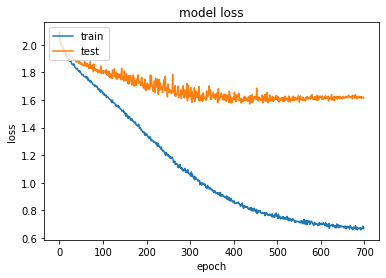

In [46]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [48]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 45.56%


In [49]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(df_male))):
    X, sample_rate = librosa.load(df_male.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(df_male.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 720/720 [00:39<00:00, 18.15it/s]


In [50]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

720/720 [==============================] - 5s 7ms/step


In [51]:
preds

array([[0.01749497, 0.00360069, 0.04679951, ..., 0.0119542 , 0.01784202,
        0.841345  ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.76193076, 0.01293825, 0.06329638, ..., 0.0085528 , 0.0316081 ,
        0.01466093],
       ...,
       [0.01744618, 0.21738778, 0.59670585, ..., 0.02543321, 0.11225901,
        0.01516088],
       [0.00121909, 0.15471774, 0.6599111 , ..., 0.00913609, 0.09684202,
        0.00089544],
       [0.01322218, 0.12251836, 0.01060341, ..., 0.4383594 , 0.05969736,
        0.01355681]], dtype=float32)

In [52]:
preds1=preds.argmax(axis=1)

In [53]:
preds

array([[0.01749497, 0.00360069, 0.04679951, ..., 0.0119542 , 0.01784202,
        0.841345  ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.76193076, 0.01293825, 0.06329638, ..., 0.0085528 , 0.0316081 ,
        0.01466093],
       ...,
       [0.01744618, 0.21738778, 0.59670585, ..., 0.02543321, 0.11225901,
        0.01516088],
       [0.00121909, 0.15471774, 0.6599111 , ..., 0.00913609, 0.09684202,
        0.00089544],
       [0.01322218, 0.12251836, 0.01060341, ..., 0.4383594 , 0.05969736,
        0.01355681]], dtype=float32)

In [54]:
flatten_preds = preds1.astype(int).flatten()

In [55]:
predictions = (lb.inverse_transform((flatten_preds)))

In [56]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,surprised
1,angry
2,angry
3,fearful
4,fearful
5,angry
6,disgust
7,sad
8,sad
9,disgust


In [57]:
actual=test_valid_lb.argmax(axis=1)
actual_flatten = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((actual_flatten)))

In [58]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,surprised
1,surprised
2,angry
3,fearful
4,fearful
5,angry
6,disgust
7,sad
8,sad
9,disgust


In [59]:
finaldf = actualdf.join(preddf)

In [60]:
finaldf[20:40]

,actualvalues,predictedvalues
20,surprised,surprised
21,surprised,angry
22,fearful,fearful
23,angry,angry
24,angry,angry
25,fearful,fearful
26,sad,sad
27,disgust,disgust
28,disgust,disgust
29,sad,sad


In [61]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,96
calm,96
disgust,96
fearful,96
happy,96
neutral,48
sad,96
surprised,96


In [62]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,335
calm,73
disgust,86
fearful,53
happy,47
neutral,13
sad,71
surprised,42


In [63]:
finaldf.to_csv('Predictions.csv', index=False)

In [64]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

40.0

In [66]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

40.635635237007364

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[58,  4, 12,  8,  1,  0,  8,  5],
       [26, 52,  5,  4,  2,  2,  5,  0],
       [27,  4, 51,  6,  2,  0,  1,  5],
       [55,  0,  4, 22,  1,  0, 10,  4],
       [42,  5,  4,  2, 35,  4,  2,  2],
       [28,  5,  0,  3,  3,  6,  2,  1],
       [35,  3,  6,  6,  2,  1, 41,  2],
       [64,  0,  4,  2,  1,  0,  2, 23]])

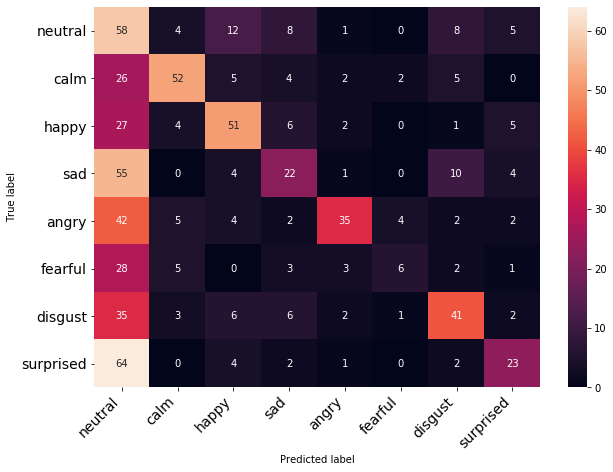

In [68]:
# Visualize Confusion Matrix 

class_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print_confusion_matrix(cm, class_names)